# Sandbox genetic algorithm

Experiments with inheritance in graphs (needs to be troubleshooted for a genetic algorithm)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

### Utility functions

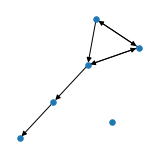

In [532]:
def plot_graph(gdict):
    """Utility: plots a graph from a gdict."""
    G = nx.Graph() # For layout only
    DG = nx.DiGraph()
    for node,edges in gdict.items():
        if not edges:
            DG.add_node(node)
            G.add_node(node)
        for other in edges:
            DG.add_edge(node, other)
            G.add_edge(node, other)
    pos=nx.kamada_kawai_layout(G)
    nx.draw(DG, node_size=30, pos=pos)
    return
    
def tinyfig():
    plt.figure(figsize=(2,2))
    
tinyfig()
plot_graph({0:[1,3], 1:[0,2], 2:[1,0], 3:[4], 5:[]})

In [7]:
def profile(g):
    """Helper function. Returns nV, nE"""
    return (len(g), len(set([(i,j) for i,js in g.items() for j in js if i<j])))

profile({0:[1,2], 1:[0,2,4], 2:[1,0,4], 4:[1,2]})

(4, 5)

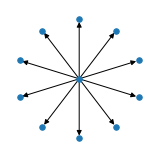

In [121]:
# Test subject: a star
def make_star(n=4):
    """Star with n-1 spikes."""    
    return {0:[i for i in range(1,n)]}

tinyfig()
plot_graph(make_star(11))

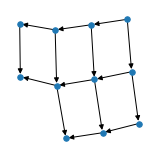

In [126]:
# Test subject 2: a grid
def make_grid(n=4):
    """Square grid of n elements."""
    m =  np.ceil(np.sqrt(n)).astype(int)    
    d = {i:[] for i in range(n)}
    address = lambda i,j: i*m + j
    for i in range(m):
        for j in range(m):                
            if address(i,j)>n: break
            if i < m-1: 
                k = address(i+1, j)
                if k<n: d[address(i,j)].append(k)
            if j < m-1: 
                k = address(i, j+1)
                if k<n: d[address(i,j)].append(k)
    return d

tinyfig()
plot_graph(make_grid(11))

(9, 12)

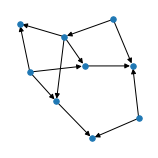

In [97]:
# Test subject 3: Random graph
def make_random(n, e=None):
    """Create oriented Erdos-like graph."""
    if e is None: e = 2*n
    edges = [(i,j) for j in range(n) for i in range(j) if i!=j] # Generate all possible edges
    edges = [edges[i] for i in np.random.choice(n*(n-1)//2, e, replace=False)] # Draw some
    g = {i:[j for k,j in edges if k==i] for i in range(n)}
    return g

tinyfig()
g = make_random(9,12)
plot_graph(g)
profile(g)

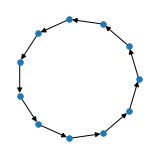

In [400]:
def make_cycle(n=4):
    """Create one loop graph of n elements."""
    return {i:[(i+1) % n] for i in range(n)}

tinyfig()
plot_graph(make_cycle(11))

Now create an undirected graph, and start percolating on it from a random node, breadth-first, but maybe randomize node sequence to avoid artifacts. If the graph is not connected, and a queue is empty, add a point at random. Run this, until 50% of nodes are covered

After this step, take all projections from covered points from this graph, and all projections from uncovered points from another graph. This way we'll take about half of edges from each of the parents, and covered-covered and remaining-remaining parts of the network will be taken in its entirey. While the covered-uncovered border will be messed up a bit.

In this variant, the number of edges will drift, and the degree distribution will change. Which is probably great, all things considered. But if it is a problem,  we can always modify the algorithm by taking both in-networks as is, then rewiring stumps at the border. (To rewire stumps at the border, first include all border edges that exist in both parents, then randomly wire the rest, going one group to another; finally if there are any unpaired stumps, wire them together within the whatever group had more stumps. As cuts in both parents will always produce an even number of stumps, this rewiring is always possible)

All functions below are written as if nodes are not `range(n)`, which may technically be an overkill. Because most probably they'll always be in `range(n)`, and `n` will be fixed. But just in case, I write everyting as if nodes were arbitrary, at least for now.

In [140]:
[(a,b) for a,b in ((1,2),(2,1))]

[(1, 2), (2, 1)]

In [197]:
def list_nodes(gdict):
    """Returns all nodes of a graph, as a set."""
    return set([i for i in gdict.keys()] + [j for i,js in gdict.items() for j in js])

def ordered_to_simple(gdict):
    """Ordered graph gdict to unordered."""    
    nodes = list_nodes(gdict)
    return {i:[j for j in nodes if (j in gdict.get(i,[]) or i in gdict.get(j,[]))] for i in nodes}

ordered_to_simple({1:[2,3], 2:[0,4]})

{0: [2], 1: [2, 3], 2: [0, 1, 4], 3: [1], 4: [2]}

In [430]:
def mark_nodes(gdict, n_target=None):
    """Returns a list of nodes marked via percolation (by default, 50%)"""
    nodes = list_nodes(gdict)
    if not n_target: n_target = np.floor(len(nodes)/2).astype(int)
    marked = set()
    queue = [] # Random choice doesn't work on sets, so using a list here
    while len(marked) < n_target:
        if not queue: # If empty queue - pick a new starting node at random                        
            queue.append(np.random.choice([i for i in nodes if i not in marked]))
        node = np.random.choice(queue) # Propagate at a random node
        queue.remove(node)
        marked.add(node)
        queue += [i for i in gdict.get(node, []) if i not in marked]
    return marked

mark_nodes(ordered_to_simple({1:[0,2], 3:[2,4], 5:[4,0]}), 4)

{1, 2, 3, 4}

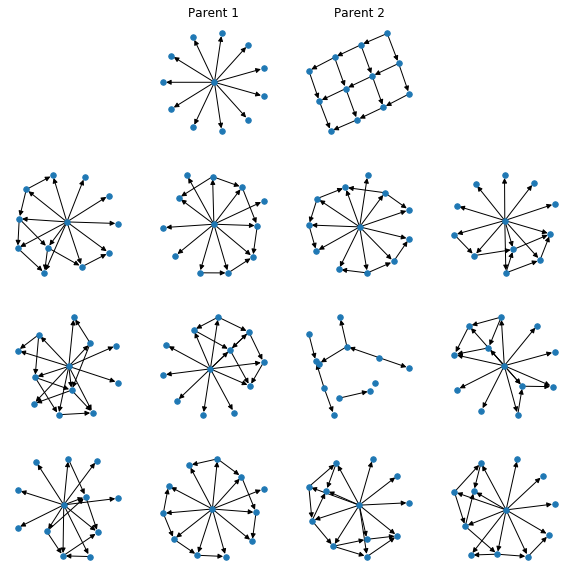

In [537]:
def cross(g1, g2):
    """Takes two gdicts, calculates a baby."""    
    if np.random.randint(2): # Toss a coin for who's the main parent
        parents = [g1, g2]        
    else:
        parents = [g2, g1]        
    g = {}
    nodes = list_nodes(parents[0])
    half_nodes = mark_nodes(parents[0])
    for node in nodes:
        if node in half_nodes:
            g[node] = parents[0].get(node,[])
        else:
            g[node] = parents[1].get(node,[])
    return g

def parenting_pic(f1, f2, n=None):
    """Nice pic to troubleshoot graph cross-breeding."""
    if not n: n=11
    g1 = f1(n)
    g2 = f2(n)
    plt.figure(figsize=(10,10));
    plt.subplot(4,4,2); plot_graph(g1); plt.title('Parent 1')
    plt.subplot(4,4,3); plot_graph(g2); plt.title('Parent 2')
    for i in range(5,17):
        plt.subplot(4,4,i);
        plot_graph(cross(g1,g2));
        
parenting_pic(make_star, make_grid, 12)

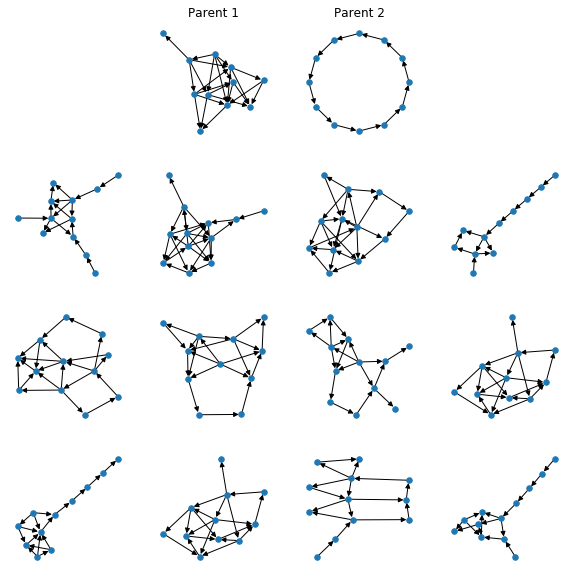

In [432]:
# Another test, with different parents

parenting_pic(make_random, make_cycle, 12)

In [488]:
def list_edges(g):
    """Returns edges from a gdict."""
    return set((i,j) for i,js in g.items() for j in js)

list_edges({0:[1,2], 1:[0,3]})

{(0, 1), (0, 2), (1, 0), (1, 3)}

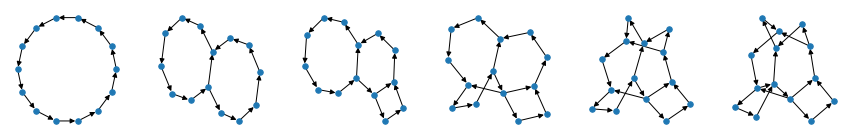

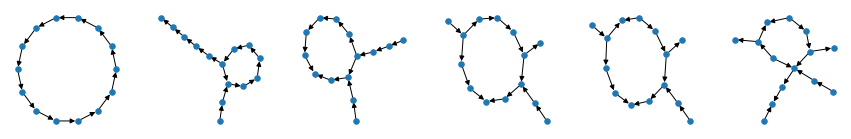

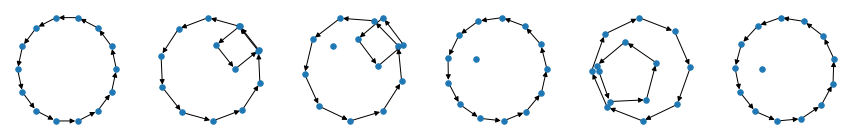

In [527]:
def mutate(gdict, k=1, method='edge'):
    """Mutate k edges. Three modes: 'stumps' (degree-preserving), 
    'edges' (N_E preserving) and 'free' (everyting is fair game).
    Written as if it's a self-method that modifies g in-place.
    No checking for repeated flipping of same edges back and forth."""
    edges = list_edges(gdict)
    nodes = list_nodes(gdict)
    
    def flip_edge(gdict, edge):
        if edge[1] in gdict.get(edge[0], []): 
            gdict[edge[0]].remove(edge[1])
        else:
            gdict[edge[0]] = gdict.get(edge[0], []) + [edge[1]]
        return gdict    
    
    if method == 'free':
        """Flip edges at random."""
        for i in range(k):
            edge = tuple(np.random.choice(list(nodes), 2, replace=False))
            if edge in edges:
                edges -= {edge}
            else:
                edges |= {edge}
            gdict = flip_edge(gdict, edge)          
    if method == 'edges':
        """Add one edge, remove another one."""
        all_edges = {(i,j) for i in list(nodes) for j in list(nodes) if i!=j}
        free_edges = list(all_edges - edges)
        edges = list(edges) # For this algo, it's handier to have it as a list
        for i in range(k):
            source = edges[np.random.randint(len(edges))]            
            target = free_edges[np.random.randint(len(free_edges))]            
            edges.remove(source)
            edges.append(target)
            free_edges.remove(target)
            free_edges.append(source)
            gdict = flip_edge(gdict, source)
            gdict = flip_edge(gdict, target)
    if method == 'stumps':
        """Find two existing edges, and cross-wire them."""
        edges = list(edges)
        for i in range(k):
            source = edges[np.random.randint(len(edges))]
            target = source
            while target==source:
                target = edges[np.random.randint(len(edges))]
            gdict = flip_edge(gdict, source)
            gdict = flip_edge(gdict, target)
            gdict = flip_edge(gdict, (source[0], target[1]))
            gdict = flip_edge(gdict, (target[0], source[1]))
    return gdict

def mutateplot(g, mode):
    plt.figure(figsize=(15, 2.3))
    plt.subplot(1,6,1)
    plot_graph(g)
    for i in range(2,7):
        g = mutate(g, 1, mode)
        plt.subplot(1,6,i)
        plot_graph(g)

# Test
n = 14
g = make_cycle(n)
mutateplot(g, 'free')
g = make_cycle(n)
mutateplot(g, 'edges')
g = make_cycle(n)
mutateplot(g, 'stumps')